# FFT Audio Data EDA

## Python note book to do the following
* Read Audio FFT(Fast Fourier transformed) transformed data from CVS.
* Drop unwanted Column.
* Each instance of audio FFT data is in String format, Convert it to numpy array.
* Create OneHotEncoded Target variable.
* Split the Data for training, testing and Validating model.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import os

### Read the data from CSV

In [2]:
df = pd.read_csv("Dataset/surrounding_audio_dataset_FFT.csv")

### Drop Unwanted Data

In [3]:
df.columns

Index(['Unnamed: 0', 'audio_rms_vec', 'target'], dtype='object')

In [4]:
df = df.drop(["Unnamed: 0"], axis=1)

In [5]:
df.head()

,audio_rms_vec,target
0,"1792, 1678, 1584, 1533, 1469, 1367, 1282, 1251...",yes
1,"92, 77, 79, 65, 73, 68, 59, 37, 27, 83, 104, 1...",yes
2,"65, 34, 36, 48, 56, 23, 44, 37, 34, 36, 32, 23...",yes
3,"90, 85, 30, 42, 50, 57, 80, 104, 117, 89, 78, ...",yes
4,"77, 37, 25, 41, 55, 19, 39, 55, 44, 31, 36, 67...",yes


In [6]:
df["target"].unique()

array(['yes', 'tauhid', 'arduino'], dtype=object)

### Create Two var, one holding Audio FFT vec data and other Target variable

In [7]:
feature_x = df['audio_rms_vec'].copy()
target_y = df["target"].copy()

In [8]:
target_y.describe()

count        150
unique         3
top       tauhid
freq          50
Name: target, dtype: object

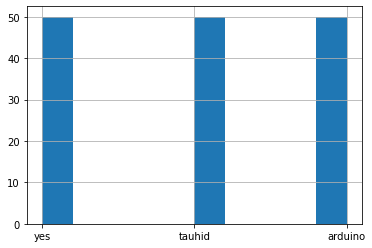

In [9]:
target_y.hist()
plt.show()

In [10]:
dataset = []

for f in feature_x:
    str_data_list = f.split(",")
    str_data_np = np.array([str_data_list])
    data_np = str_data_np.astype(np.float)
    dataset.append(data_np)
    
dataset_np = np.array(dataset)
dataset_np = np.squeeze(dataset_np)

In [11]:
dataset_np.shape

(150, 128)

### OneHot encoding target variable

In [12]:
oh_enc = OneHotEncoder(sparse=False)

In [13]:
target_y = target_y.to_numpy()

In [14]:
target_y = target_y.reshape(-1,1)

In [15]:
target_encoded = oh_enc.fit_transform(target_y)

In [16]:
target_encoded = target_encoded.astype(np.float32)

### Ploting Frequency Spectrum

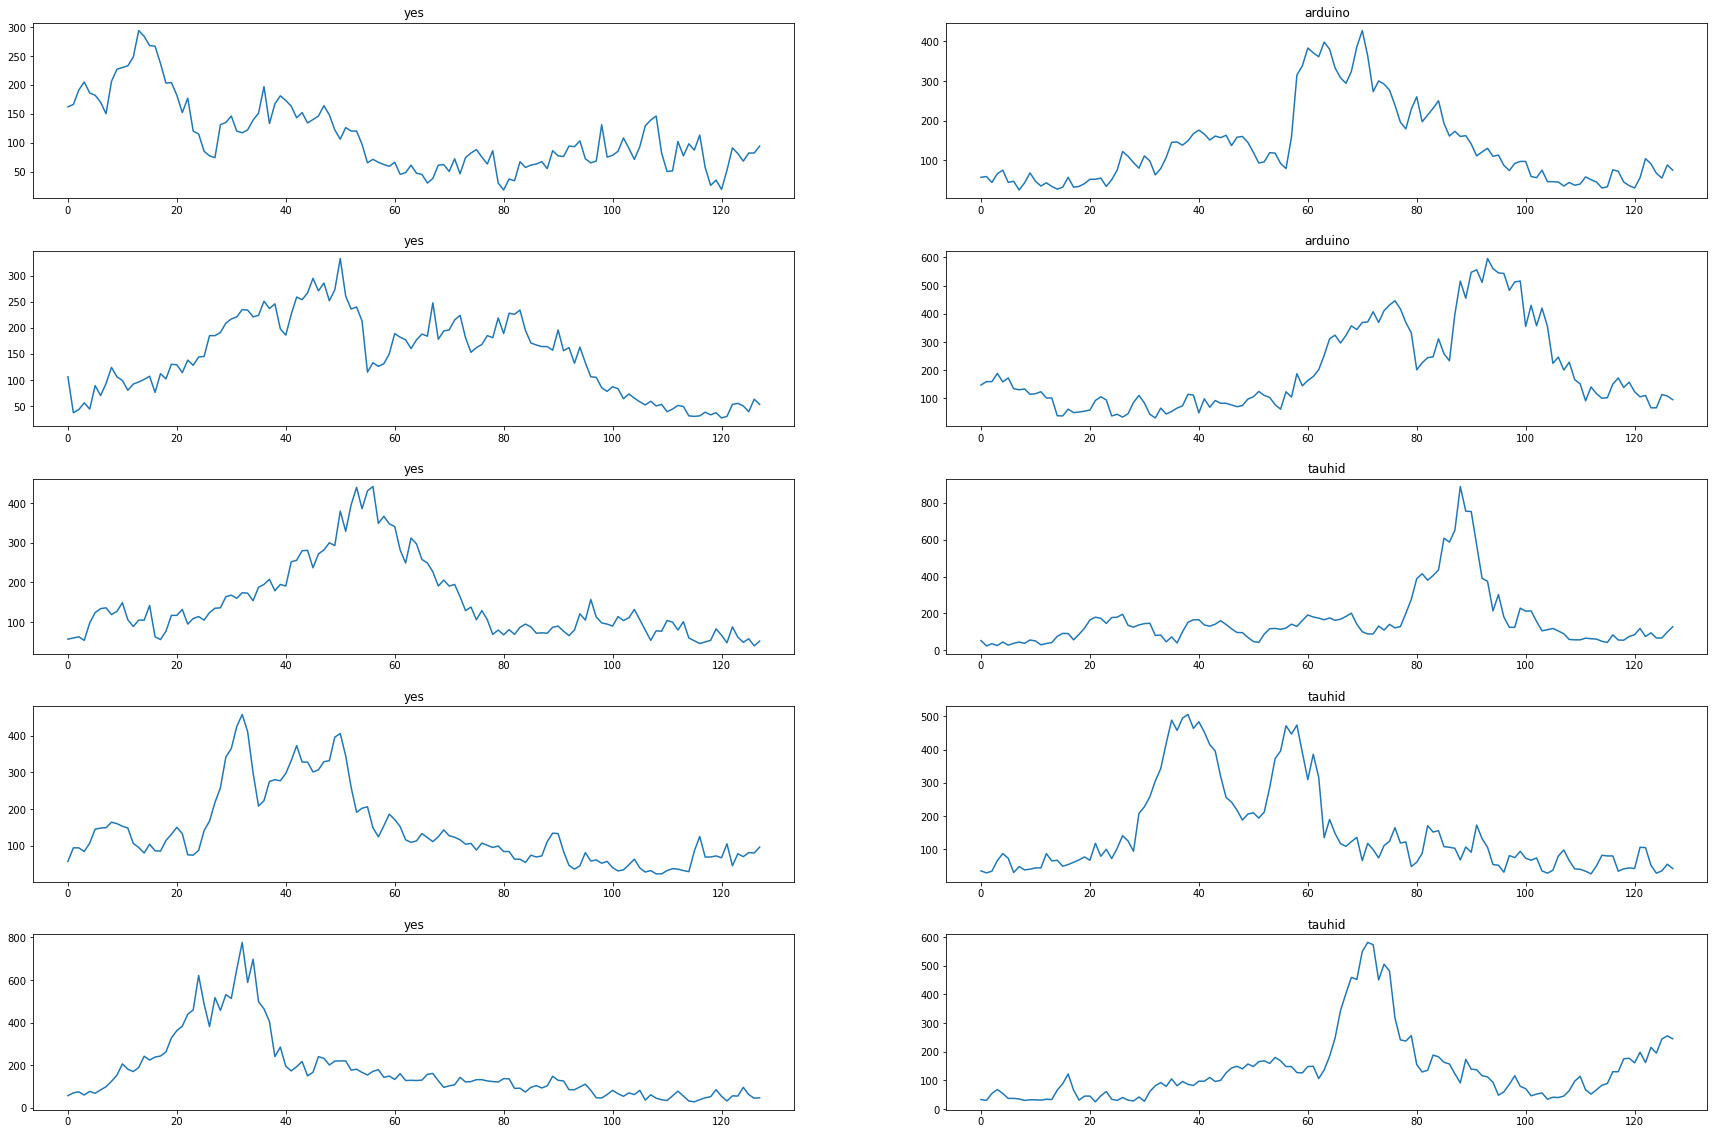

In [17]:
def plot_fft_audio_spectrum():
    fig = plt.figure(figsize=(30, 20))
    fig.subplots_adjust(hspace=0.3, wspace=0.2)
    for i in range(10):
        randvar = np.random.randint(0,target_encoded.shape[0])
        plt.subplot(5, 2, i+1)
        plt.title(df["target"][randvar])
        plt.plot(dataset_np[randvar].reshape(-1, 1))


plot_fft_audio_spectrum()


### Viausalizing Data in Lower dimension using PCA

In [18]:
import plotly.express as px
from sklearn.decomposition import PCA

In [19]:
pca = PCA(n_components=3)

In [20]:
components = pca.fit_transform(dataset_np)
total_var = pca.explained_variance_ratio_.sum() * 100

In [21]:
# fig = px.scatter_3d(
#     components, x=0, y=1, z=2, color=df['target'],
#     title=f'Total Explained Variance: {total_var:.2f}%',
#     labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'}
# )
# fig.show()

fig = px.scatter(
    components, x=0, y=1, color=df['target'],
    title=f'Total Explained Variance: {total_var:.2f}%',
    labels={'0': 'PC 1', '1': 'PC 2'}
)
fig.show()

### Splitting Dataset into train validate and test

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(dataset_np,target_encoded,test_size=0.2,train_size=0.8,random_state=20,shuffle = True)

In [23]:
print(X_train.shape,
X_test.shape,
Y_train.shape,
Y_test.shape
)

(120, 128) (30, 128) (120, 3) (30, 3)


In [24]:
# X_train = X_train/X_train.max()

In [25]:
# X_test = X_test/X_test.max()

# DL model Creating, Training, and Converting to C arrays

In [26]:
import tensorflow as tf

In [27]:
from tensorflow.keras.layers import Dense, ReLU, Softmax, InputLayer, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.optimizers import Adam, RMSprop

from sklearn.metrics import classification_report

In [28]:
EPOCH = 200
LEARNING_RATE = 0.0001
BATCH_SIZE = 8

## Liner MLP model

In [29]:
audio_fft_in = Input(shape=(X_train.shape[1],))
x = Dense(128, activation='relu')(audio_fft_in)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(np.unique(target_y).size,activation='softmax')(x)

model = Model(inputs=audio_fft_in, outputs=output)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0     

In [30]:
model.compile(
    loss='categorical_crossentropy',
    optimizer = Adam(),
    metrics=[Accuracy()]
)

In [31]:
hist = model.fit(X_train, Y_train, epochs=EPOCH, batch_size=BATCH_SIZE)

Epoch 1/200
15/15 [==============================] - 1s 2ms/step - loss: 131.0167 - accuracy: 0.4033
Epoch 2/200
15/15 [==============================] - 0s 2ms/step - loss: 51.5721 - accuracy: 0.2492
Epoch 3/200
15/15 [==============================] - 0s 2ms/step - loss: 32.0519 - accuracy: 0.1176
Epoch 4/200
15/15 [==============================] - 0s 2ms/step - loss: 22.5539 - accuracy: 0.0658
Epoch 5/200
15/15 [==============================] - 0s 2ms/step - loss: 18.5021 - accuracy: 0.0748
Epoch 6/200
15/15 [==============================] - 0s 2ms/step - loss: 12.5785 - accuracy: 0.0439
Epoch 7/200
15/15 [==============================] - 0s 2ms/step - loss: 8.0170 - accuracy: 0.0267 
Epoch 8/200
15/15 [==============================] - 0s 2ms/step - loss: 6.9435 - accuracy: 0.0057
Epoch 9/200
15/15 [==============================] - 0s 3ms/step - loss: 8.4304 - accuracy: 0.0141
Epoch 10/200
15/15 [==============================] - 0s 3ms/step - loss: 3.7635 - accuracy: 0.0208
E